# 📉 Telco Customer Retention Strategy: AI-Powered Churn Analysis
**Project by: Stephen Richard | Aspiring AI Product Manager**

### 🎯 Business Objective
Mencegah kerugian pendapatan (Revenue Loss) dengan memprediksi customer yang berpotensi berhenti berlangganan (Churn), serta mengidentifikasi **akar masalah** (Root Cause) kenapa mereka pergi.

### 🛠️ Tech Stack
* **Python** (Data Processing)
* **Pandas & NumPy** (Data Manipulation)
* **Seaborn & Matplotlib** (Business Visualization)
* **Scikit-Learn** (Random Forest)
* **CatBoost** (Advanced Gradient Boosting)

**Setup & Data Ingestion**

In [1]:
# Install Library CatBoost (Jika di Google Colab)
# !pip install catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from catboost import CatBoostClassifier

# Setup Visualisasi
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# 1. Load Data
df = pd.read_csv('Telco_customer_churn.csv')

# 2. Basic Cleaning
# Mengubah Total Charges jadi angka & isi nilai kosong
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce').fillna(0)

# Buang kolom yang tidak relevan untuk prediksi
drop_cols = ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 
            'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Score', 
            'CLTV', 'Churn Reason'] # Churn Reason kita simpan buat analisis terpisah nanti

df_clean = df.drop(columns=drop_cols)

print(f"✅ Data Ready! Total Customers: {len(df_clean)}")
print(f"Churn Rate Global: {df['Churn Value'].mean()*100:.2f}%")

✅ Data Ready! Total Customers: 7043
Churn Rate Global: 26.54%


**EDA**

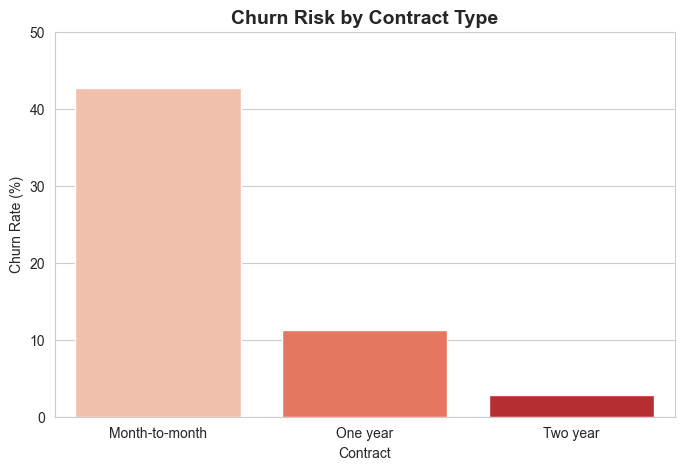

Insight: Pengguna 'Month-to-month' memiliki risiko churn sangat tinggi (>40%).


In [2]:
# Analisis Churn berdasarkan Kontrak
contract_churn = df.groupby('Contract')['Churn Value'].mean().reset_index()
contract_churn['Churn Rate (%)'] = contract_churn['Churn Value'] * 100

plt.figure(figsize=(8, 5))
sns.barplot(
    x='Contract', 
    y='Churn Rate (%)', 
    data=contract_churn, 
    palette='Reds', 
    hue='Contract', 
    legend=False
)

plt.title('Churn Risk by Contract Type', fontsize=14, fontweight='bold')
plt.ylabel('Churn Rate (%)')
plt.ylim(0, 50)
plt.show()

print("Insight: Pengguna 'Month-to-month' memiliki risiko churn sangat tinggi (>40%).")

**PREPROCESSING**

In [3]:
# 1. Encoding (Mengubah Kategori Teks menjadi Angka)
df_processed = pd.get_dummies(df_clean, drop_first=True)

# 2. Scaling (Menyamakan Skala Data Numerik)
scaler = StandardScaler()
num_cols = ['Tenure Months', 'Monthly Charges', 'Total Charges']
df_processed[num_cols] = scaler.fit_transform(df_processed[num_cols])

# 3. Split Data (80% Train, 20% Test)
X = df_processed.drop('Churn Value', axis=1)
y = df_processed['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data Split Completed.")
print(f"Training Data: {X_train.shape[0]} rows")
print(f"Testing Data : {X_test.shape[0]} rows")

✅ Data Split Completed.
Training Data: 5634 rows
Testing Data : 1409 rows


**MODEL TRAINING**

In [4]:
# === MODEL 1: RANDOM FOREST (Baseline) ===
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

# === MODEL 2: CATBOOST (Challenger) ===
model_cat = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
model_cat.fit(X_train, y_train)
y_pred_cat = model_cat.predict(X_test)
acc_cat = accuracy_score(y_test, y_pred_cat)

print("🏆 MODEL BATTLE RESULT")
print(f"Random Forest Accuracy : {acc_rf*100:.2f}%")
print(f"CatBoost Accuracy      : {acc_cat*100:.2f}%")

if acc_cat > acc_rf:
    print("✅ WINNER: CatBoost")
else:
    print("✅ WINNER: Random Forest")

🏆 MODEL BATTLE RESULT
Random Forest Accuracy : 78.64%
CatBoost Accuracy      : 79.21%
✅ WINNER: CatBoost


**FEATURE IMPORTANCE**

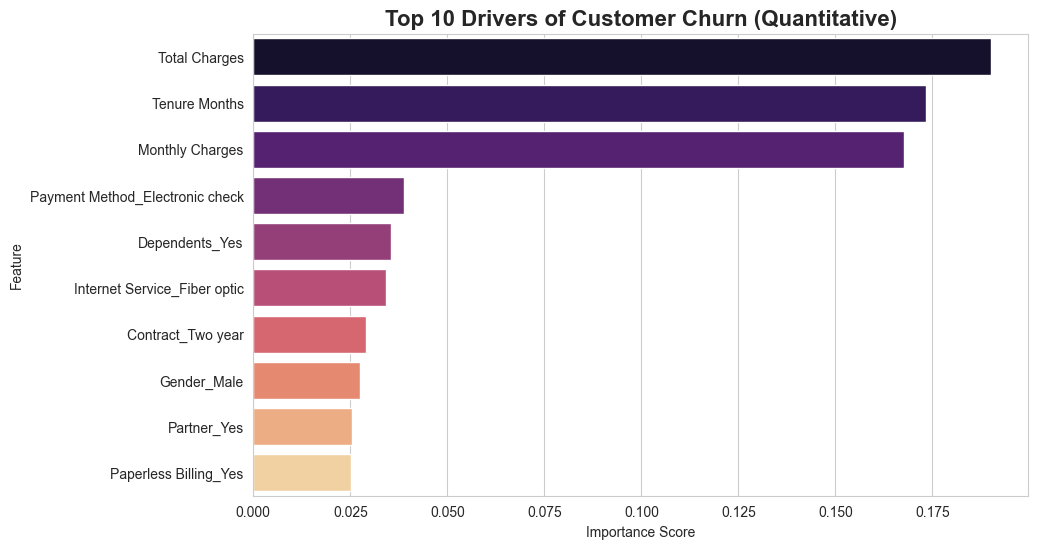

In [5]:
# Mengambil "Otak" dari Random Forest untuk melihat faktor dominan
importances = model_rf.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_imp_df, 
    palette='magma', 
    hue='Feature', 
    legend=False
)

plt.title('Top 10 Drivers of Customer Churn (Quantitative)', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score')
plt.show()

**VOICE OF CUSTOMER**

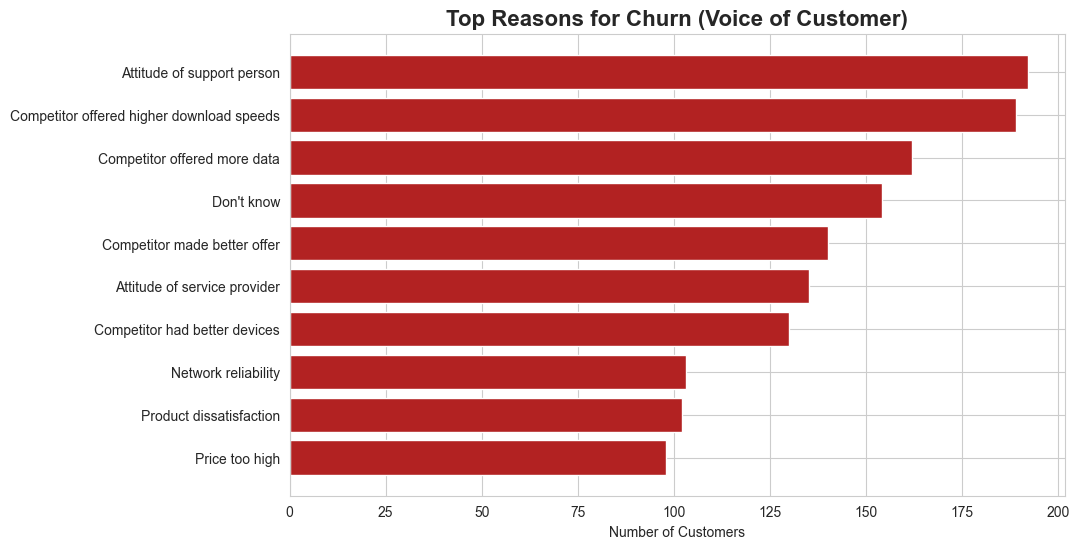

🚨 MAIN ROOT CAUSE: Attitude of support person


In [6]:
# Analisis Kolom 'Churn Reason' (Data Asli)
df_churn = df[df['Churn Value'] == 1]
reason_counts = df_churn['Churn Reason'].value_counts().head(10)

plt.figure(figsize=(10, 6))
plt.barh(reason_counts.index, reason_counts.values, color='firebrick')
plt.title('Top Reasons for Churn (Voice of Customer)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Customers')
plt.gca().invert_yaxis() # Urutkan dari atas ke bawah
plt.show()

print(f"🚨 MAIN ROOT CAUSE: {reason_counts.index[0]}")

### 🚀 Strategic Recommendations (CPO Perspective)

Based on the quantitative (ML) and qualitative (Reason) analysis, here is the action plan:

1.  **Fix the Service Attitude (Immediate):**
    * Data shows **"Attitude of support person"** is the #1 reason for churn (192 cases).
    * **Action:** Retrain CS team, implement stricter quality control for support calls.

2.  **Loyalty Program for High Spenders (Retention):**
    * Feature Importance shows **Total Charges** & **Tenure** are key indicators.
    * **Action:** Customers with high tenure who pay a lot feel "neglected". Create a "VIP Tier" with exclusive perks to lock them in.

3.  **Migrate Month-to-Month Users:**
    * Users on monthly contracts have >40% churn rate.
    * **Action:** Offer a **20% discount** for users who switch to a 1-year or 2-year contract.